# Covid-19
## Analises Inicias do Cenário da Pandemia no Brasil



### Importando sa Bibliotecas



In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import folium
from folium import plugins
import json
import os
import requests
import io

pd.set_option('display.max_colwidth', 1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Funções Utilitarias

In [ ]:
def indicators(xs, ys, rotation, align, font):
  for x,y in zip(xs,ys):
    label = "{:.0f}".format(y)
    if align == 'h':
      plt.annotate(
          label,
          (y, x),
          textcoords="offset pixels",
          xytext=(5,0),
          va="center",
          rotation=rotation,
          size=font
      )
    if align == 'v':
      plt.annotate(
          label,
          (x, y),
          textcoords="offset pixels",
          xytext=(0,5),
          ha="center",
          rotation=rotation,
          size=font
      )

# Mapa Base 
#tiles (cartodbpositron, Stamen Tonr, Stamen Terrain)
def baseMap(tiles, zoom, location):
    baseMap = folium.Map(
        width="50%",
        height="50%",
        location=location,
        zoom_start=zoom,
        tiles=tiles
    )
    return baseMap

def fullscreen(mapa):
  plugins.Fullscreen(
      position='topright',
      title='FullScreen',
      title_cancel='Exit',
      force_separate_button=True
  ).add_to(mapa)


### Criando o DataSet
> Dados importados da base do brasil.io em tempo real sobre o Covid-19.

In [ ]:
# Covid BrasilIO
#urlcsv = 'https://brasil.io/dataset/covid19/caso?format=csv'
#covid = pd.read_csv(urlcsv)
urlCovid = 'https://brasil.io/dataset/covid19/caso?format=csv'
header = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36","X-Requested-With": "XMLHttpRequest"}
res = requests.get(url = urlCovid, headers = header)
req = io.StringIO(res.content.decode('utf-8'))
covid = pd.read_csv(req)

# Codigos IBGE
urlibge = 'https://raw.githubusercontent.com/sandeco/CanalSandeco/master/covid-19/cidades_brasil.csv'
ibge = pd.read_csv(urlibge)

# Unificando os DataSets
covidIbge = pd.merge(covid, ibge, left_on='city_ibge_code', right_on='codigo_ibge', how='left')

# DataSet de recovereds
urlBrasil = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-total.csv'
brasilrecov = pd.read_csv(urlBrasil)
brasilRecov = brasilrecov.loc[brasilrecov.state != 'TOTAL', ['state','recovered']]

> Montando a estrutura do GeoJson Brasil

In [ ]:
#br_states = os.path.join('./gis-dataset-brasil-master/mesorregiao/geojson', 'mesorregiao.json')
brasil_json = 'https://raw.githubusercontent.com/fititnt/gis-dataset-brasil/master/mesorregiao/geojson/mesorregiao.json'
#geo_brasil = json.load(open(br_states))
geo_brasil2 = json.loads(requests.get(brasil_json).text)

> Criando DataSets dos estados

In [ ]:
estados = covidIbge.loc[(covidIbge.place_type == 'state') & (covidIbge.is_last == True), ['state', 'confirmed', 'deaths', 'latitude', 'longitude']].sort_values(by=['state']).set_index('state').reset_index()

# Mapeamento dos Estados com Geolocalização
estadosGeo ={
    'AC': [ -8.77, -70.55]
    ,'AL': [ -9.71, -35.73]
    ,'AM': [ -3.07, -61.66]
    ,'AP': [  1.41, -51.77]
    ,'BA': [-12.96, -38.51]
    ,'CE': [ -3.71, -38.54]
    ,'DF': [-15.83, -47.86]
    ,'ES': [-19.19, -40.34]
    ,'GO': [-16.64, -49.31]
    ,'MA': [ -2.55, -44.30]
    ,'MT': [-12.64, -55.42]
    ,'MS': [-20.51, -54.54]
    ,'MG': [-18.10, -44.38]
    ,'PA': [ -5.53, -52.29]
    ,'PB': [ -7.06, -35.55]
    ,'PR': [-24.89, -51.55]
    ,'PE': [ -8.28, -35.07]
    ,'PI': [ -8.28, -43.68]
    ,'RJ': [-22.84, -43.15]
    ,'RN': [ -5.22, -36.52]
    ,'RO': [-11.22, -62.80]
    ,'RS': [-30.01, -51.22]
    ,'RR': [  1.89, -61.22]
    ,'SC': [-27.33, -49.44]
    ,'SE': [-10.90, -37.07]
    ,'SP': [-23.55, -46.64]
    ,'TO': [-10.25, -48.25]
}

estados[['latitude', 'longitude']] = [estadosGeo[i] for i in estados['state']]
estados['mortalidade_p'] = estados['deaths'] / estados['confirmed'] * 100

# Unificando DataSet de Recuperados
estados = pd.merge(estados, brasilRecov, left_on='state', right_on='state', how='left')
estados['recovered_p'] = estados['recovered'] / estados['confirmed']
estados.fillna(0, inplace=True)

estados.columns.to_list()

['state',
 'confirmed',
 'deaths',
 'latitude',
 'longitude',
 'mortalidade_p',
 'recovered',
 'recovered_p']

## Primeira visão do Cenário Atual da Pandemia

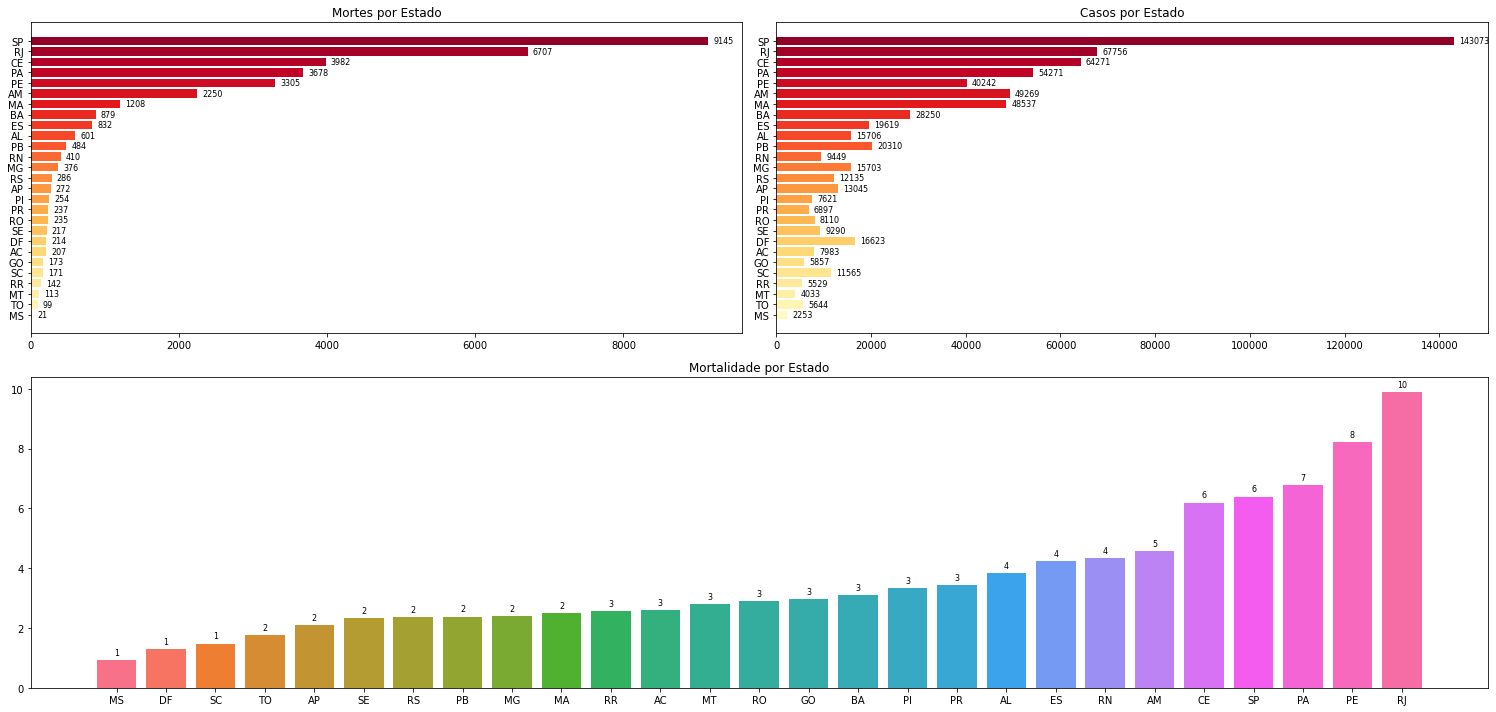

In [ ]:
x = estados[['state', 'deaths']].sort_values(by=['deaths'])['state']
y = estados[['state', 'deaths']].sort_values(by=['deaths'])['deaths']
w = estados[['state', 'deaths','confirmed']].sort_values(by=['deaths'])['confirmed']
z = estados[['state', 'deaths','mortalidade_p']].sort_values(by=['deaths'])['mortalidade_p']


fig = plt.figure(figsize=[21,10])
gs = fig.add_gridspec(2,2)
# Grafico 1
im1 = fig.add_subplot(gs[0, 0])
im1.barh(x,y, color=sns.color_palette("YlOrRd", 27))
im1.set_title('Mortes por Estado')
indicators(x, y, 0, 'h', 8)

# Grafico 2
im2 = fig.add_subplot(gs[0, 1])
im2.barh(x,w, color=sns.color_palette("YlOrRd", 27))
im2.set_title('Casos por Estado')
indicators(x, w, 0, 'h', 8)

# Grafico 3
im3 = fig.add_subplot(gs[1, :])
im3.bar(estados[['state', 'mortalidade_p']].sort_values(by=['mortalidade_p'])['state']
        ,estados[['state', 'mortalidade_p']].sort_values(by=['mortalidade_p'])['mortalidade_p']
        , color=sns.color_palette("husl", 27))
im3.set_title('Mortalidade por Estado')
indicators(estados[['state', 'mortalidade_p']].sort_values(by=['mortalidade_p'])['state']
           ,estados[['state', 'mortalidade_p']].sort_values(by=['mortalidade_p'])['mortalidade_p']
           ,0,'v',8)

fig.tight_layout()
plt.show()

## Cenário de Recuperados

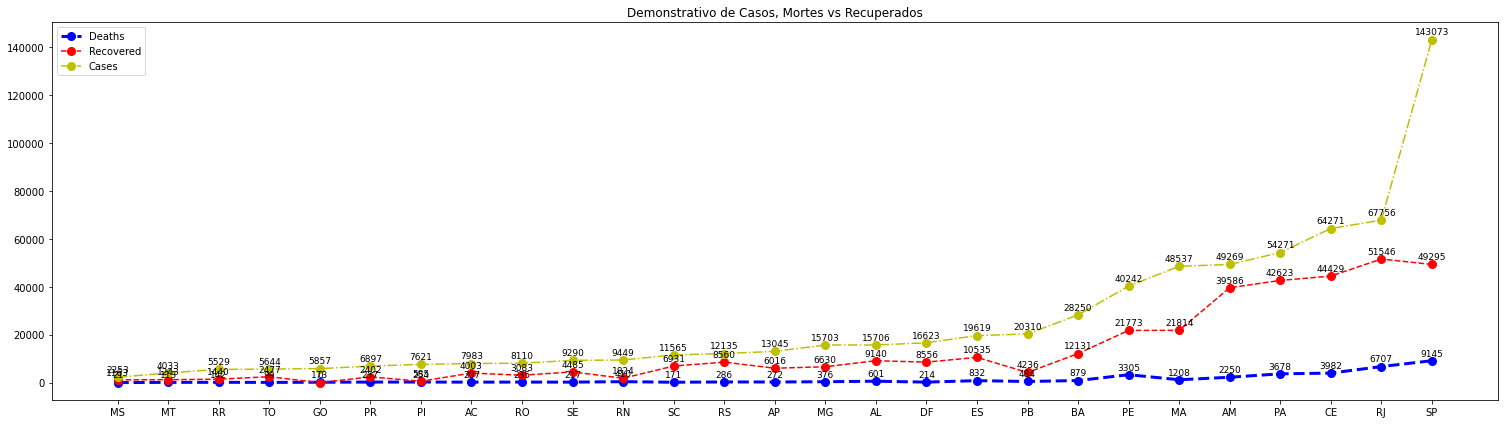

In [ ]:
x = estados.sort_values(by='confirmed')['state']
y = estados.sort_values(by='confirmed')['deaths']
z = estados.sort_values(by='confirmed')['recovered']
w = estados.sort_values(by='confirmed')['confirmed']

fig = plt.figure(figsize=[21,6])
plt.plot(x,y, 'bo--', label='Deaths', linewidth=3, markersize=8)
plt.plot(x,z, 'ro--', label='Recovered', markersize=8)
plt.plot(x,w, 'yo-.', label='Cases', markersize=8)
plt.legend()
plt.title('Demonstrativo de Casos, Mortes vs Recuperados')
indicators(x, z, 0, 'v', 9)
indicators(x, y, 0, 'v', 9)
indicators(x, w, 0, 'v', 9)

fig.tight_layout()
plt.show()

# Mapa apresentando os casos de Morte no Brasil

> Montando o Mapa com o Cenário Atual dos Casos Confirmados

In [ ]:
# Mapa Principal (Stamen Toner, Stamen Terrain)
brasil = [-15.788497, -47.879873]
m = baseMap("Stamen Toner",4, brasil)

# plotando o circle no mapa
for i in range(0,len(estados)):
    folium.Circle(
        location=[estados.iloc[i]['latitude'], estados.iloc[i]['longitude']],
        color = '#DB3232', fill = True, color_fill = '#420404',
        tooltip= '<b> Casos Confirmados ' +
                 '<li> Estado.: '+ str(estados.iloc[i]['state']) + '</li>' +
                 '<li> Casos.: ' + str(estados.iloc[i]['confirmed']) + '</li>' +
                 '<li> Mortes.: '+ str(estados.iloc[i]['deaths']) + '</li>' +
                 '<li> Mortalidade.: '+ str("{:.1f}".format(estados.iloc[i]['mortalidade_p'])) + '%</li>',
        radius = (estados.iloc[i]['confirmed']**1.05)
    ).add_to(m)

for i in range(0,len(estados)):
    folium.Circle(
        location=[estados.iloc[i]['latitude'], estados.iloc[i]['longitude']],
        color = '#138F36', fill = True, color_fill='#004213',
        tooltip= '<b> Mortes Confirmadas ' +
                 '<li> Estado.: '+ str(estados.iloc[i]['state']) + '</li>' +
                 '<li> Casos.: ' + str(estados.iloc[i]['confirmed']) + '</li>' +
                 '<li> Mortes.: '+ str(estados.iloc[i]['deaths']) + '</li>' +
                 '<li> Mortalidade.: '+ str("{:.1f}".format(estados.iloc[i]['mortalidade_p'])) + '%</li>',
        radius = (estados.iloc[i]['deaths']**1.05)
    ).add_to(m)

m

In [ ]:
cidadesCoor = covidIbge.loc[(covidIbge.place_type == 'city') & (covidIbge.state == 'SP'), ['latitude', 'longitude', 'date', 'confirmed']].groupby(['latitude', 'longitude', 'date'], sort=False)['confirmed'].sum().reset_index()
cidadesCoor = cidadesCoor.dropna()
#cidadesCoor = cidadesCoor.set_index('date')
display(len(cidadesCoor))
cidadesCoor[:10]

24139

latitude  longitude        date  confirmed
0 -21.68    -51.07      2020-06-07  42       
1 -21.23    -49.65      2020-06-07  3        
2 -22.06    -46.97      2020-06-07  47       
3 -21.93    -46.72      2020-06-07  1        
4 -22.47    -46.63      2020-06-07  17       
5 -22.88    -49.24      2020-06-07  1        
6 -22.60    -47.87      2020-06-07  2        
7 -22.47    -48.99      2020-06-07  34       
8 -23.55    -47.90      2020-06-07  5        
9 -21.95    -51.41      2020-06-07  3

In [ ]:
brasil = [-15.788497, -47.879873]
m = baseMap("cartodbpositron", 4, brasil)
folium.Choropleth(
    geo_data=geo_brasil2,
    name='choropleth',
    data=estados,
    columns=['state', 'deaths'],
    key_on='feature.properties.UF',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='Casos'
).add_to(m)

# plota pontos no mapa com as informacoes
for index,row in estados.iterrows():
    html = f"""
        <table)
            <tr>
                <th><b>{row['state']}</th>
            </tr>
            <tr>
                <td><h6>Mortes: {str("{:.0f}".format(row['deaths']))}</h6></td>
                <td><h6>Casos: {str("{:.0f}".format(row['confirmed']))}</h6></td>
            </tr>
        </table>
        """
    folium.Marker(
        location = [row['latitude'],row['longitude']],
        #popup    = html,
        tooltip  = html,
        icon     = plugins.BeautifyIcon(
                            border_color='#00ABDC',
                            text_color='#00ABDC',
                            number=row['state'],
                            inner_icon_style='margin-top:0;')
    ).add_to(m)
m